<a href="https://colab.research.google.com/github/samirgadkari/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [41]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [42]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [43]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=234.12639978212496, mobile=True), User(purchased=False, time_on_site=184.98891706556935, mobile=True), User(purchased=False, time_on_site=248.73966598752736, mobile=True), User(purchased=False, time_on_site=5.603679253369869, mobile=True), User(purchased=False, time_on_site=34.40649261794704, mobile=True), User(purchased=False, time_on_site=296.9293310707309, mobile=True), User(purchased=False, time_on_site=182.33808852629434, mobile=True), User(purchased=False, time_on_site=547.1115601998359, mobile=False), User(purchased=False, time_on_site=81.96175093685238, mobile=True), User(purchased=False, time_on_site=251.49788691627197, mobile=False)]


In [44]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,234.126400,True
1,False,184.988917,True
2,False,248.739666,True
3,False,5.603679,True
4,False,34.406493,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.2109450715984105,5.464638207539852,5.513221235103223,5.641149731239146,5.74997630784716,5.889838003482058,6.284004561260051,6.829960631216221,7.02578113512759,7.151369999976382,...,581.3393098400824,582.0080169010536,582.0361052263339,582.3490557355324,583.6166002395104,589.1527437334952,589.7271186218869,590.4120394256123,592.1207160828138,595.1646715124776
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,258,304,178,43,60
True,60,61,23,7,6


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,0.811321,0.832877,0.885572,0.86,0.909091
True,0.188679,0.167123,0.114428,0.14,0.090909


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.912,0.82
True,0.088,0.18


In [45]:
pd.crosstab(user_data['purchased'], user_data['mobile'], margins = True, margins_name = 'Total')

mobile,False,True,Total
purchased,,,
False,228,602,830
True,22,148,170
Total,250,750,1000


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

import pandas as pd
import matplotlib.pyplot as plt

persons_raw = pd.read_csv('https://raw.githubusercontent.com/samirgadkari/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv',
                          usecols = ['age', 'weight', 'exercise_time'])

In [54]:
persons = persons_raw.astype(float)
print('Number of NAs:', persons.isna().sum().sum())
print(persons.dtypes)
print(persons.describe())
print(persons.head())

Number of NAs: 0
age              float64
weight           float64
exercise_time    float64
dtype: object
               age       weight  exercise_time
count  1200.000000  1200.000000    1200.000000
mean     48.396667   153.540833     134.910833
std      18.166802    35.132182      85.548895
min      18.000000   100.000000       0.000000
25%      33.000000   125.000000      65.000000
50%      48.000000   149.000000     122.000000
75%      64.000000   180.250000     206.000000
max      80.000000   246.000000     300.000000
    age  weight  exercise_time
0  44.0   118.0          192.0
1  41.0   161.0           35.0
2  46.0   128.0          220.0
3  39.0   216.0           57.0
4  28.0   116.0          182.0


In [0]:

age_bins = pd.cut(persons.age, 3)
weight_bins = pd.cut(persons.weight, 3)
exercise_time_bins = pd.cut(persons.exercise_time, 3)

# Don't know why this is failing with error:
#   could not convert string to float: 'Total'
# 
# Tried to change all values of the dataframe to floats,
# but the problem persists.
# pd.crosstab([age_bins, weight_bins], exercise_time_bins, margins = True, margins_name = 'Total')
age_and_weight_vs_time = pd.crosstab([age_bins, weight_bins], exercise_time_bins)
time_and_weight_vs_age = pd.crosstab([exercise_time_bins, weight_bins], age_bins)
time_and_age_vs_weight = pd.crosstab([exercise_time_bins, age_bins], weight_bins)

In [77]:
age_and_weight_vs_time

exercise_time                        (-0.3, 100.0]  (100.0, 200.0]  \
age              weight                                              
(17.938, 38.667] (99.854, 148.667]              51              78   
                 (148.667, 197.333]             51              62   
                 (197.333, 246.0]               42               9   
(38.667, 59.333] (99.854, 148.667]              35              52   
                 (148.667, 197.333]             50              46   
                 (197.333, 246.0]               38              11   
(59.333, 80.0]   (99.854, 148.667]              74              61   
                 (148.667, 197.333]             91              57   
                 (197.333, 246.0]               73               8   

exercise_time                        (200.0, 300.0]  
age              weight                              
(17.938, 38.667] (99.854, 148.667]              103  
                 (148.667, 197.333]              30  
                 (197.333, 246.0]                 0  
(38.667, 59.333] (99.854, 148.667]              126  
                 (148.667, 197.333]              26  
                 (197.333, 246.0]                 0  
(59.333, 80.0]   (99.854, 148.667]               18  
                 (148.667, 197.333]               8  
                 (197.333, 246.0]                 0

In [78]:
time_and_weight_vs_age

age                                (17.938, 38.667]  (38.667, 59.333]  \
exercise_time  weight                                                   
(-0.3, 100.0]  (99.854, 148.667]                 51                35   
               (148.667, 197.333]                51                50   
               (197.333, 246.0]                  42                38   
(100.0, 200.0] (99.854, 148.667]                 78                52   
               (148.667, 197.333]                62                46   
               (197.333, 246.0]                   9                11   
(200.0, 300.0] (99.854, 148.667]                103               126   
               (148.667, 197.333]                30                26   
               (197.333, 246.0]                   0                 0   

age                                (59.333, 80.0]  
exercise_time  weight                              
(-0.3, 100.0]  (99.854, 148.667]               74  
               (148.667, 197.333]              91  
               (197.333, 246.0]                73  
(100.0, 200.0] (99.854, 148.667]               61  
               (148.667, 197.333]              57  
               (197.333, 246.0]                 8  
(200.0, 300.0] (99.854, 148.667]               18  
               (148.667, 197.333]               8  
               (197.333, 246.0]                 0

In [79]:
time_and_age_vs_weight

weight                           (99.854, 148.667]  (148.667, 197.333]  \
exercise_time  age                                                       
(-0.3, 100.0]  (17.938, 38.667]                 51                  51   
               (38.667, 59.333]                 35                  50   
               (59.333, 80.0]                   74                  91   
(100.0, 200.0] (17.938, 38.667]                 78                  62   
               (38.667, 59.333]                 52                  46   
               (59.333, 80.0]                   61                  57   
(200.0, 300.0] (17.938, 38.667]                103                  30   
               (38.667, 59.333]                126                  26   
               (59.333, 80.0]                   18                   8   

weight                           (197.333, 246.0]  
exercise_time  age                                 
(-0.3, 100.0]  (17.938, 38.667]                42  
               (38.667, 59.333]                38  
               (59.333, 80.0]                  73  
(100.0, 200.0] (17.938, 38.667]                 9  
               (38.667, 59.333]                11  
               (59.333, 80.0]                   8  
(200.0, 300.0] (17.938, 38.667]                 0  
               (38.667, 59.333]                 0  
               (59.333, 80.0]                   0

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


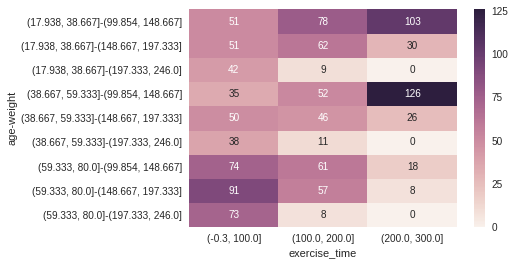

In [90]:
!pip install seaborn --upgrade
%matplotlib inline

import seaborn as sns

sns.heatmap(age_and_weight_vs_time, annot = True, fmt = 'd');

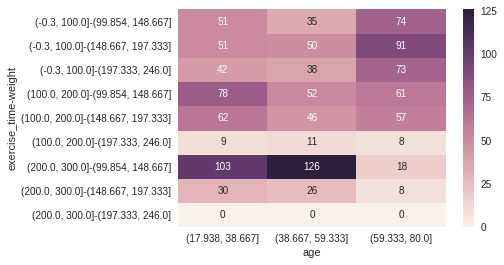

In [91]:
sns.heatmap(time_and_weight_vs_age, annot = True, fmt = 'd');

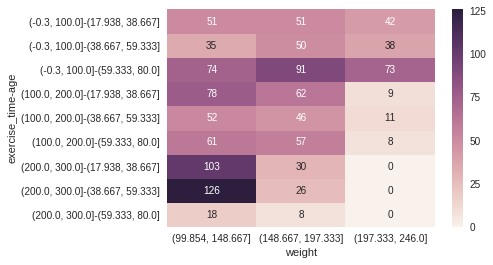

In [92]:
sns.heatmap(time_and_age_vs_weight, annot = True, fmt = 'd');

Text(0.5,1,'Exercies Time histogram')

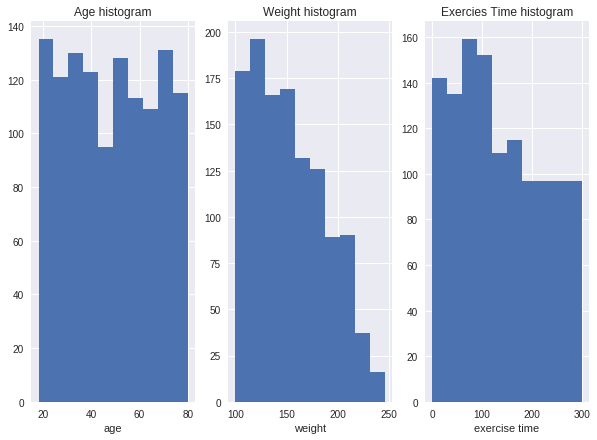

In [25]:
fig, ax = plt.subplots(1, 3, figsize = (10, 7))
ax[0].hist(persons.age)
ax[0].set_xlabel('age')
ax[0].set_title('Age histogram')

ax[1].hist(persons.weight)
ax[1].set_xlabel('weight')
ax[1].set_title('Weight histogram')

ax[2].hist(persons.exercise_time)
ax[2].set_xlabel('exercise time')
ax[2].set_title('Exercies Time histogram')


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
The variable types are all integers. I had them converted to a float, but that was to see if I could work around an issue.

2.  What are the relationships between the variables?
As age increases, the exercise time decreases.
As age increases, the exercise time decreases.
From the time_and_age_vs_weight heat map, we see that there are very few or none heavier people.  Those that are heavy, are younger and exercise more.

3.  Which relationships are "real", and which spurious?
As age increases, exercise time drops is spurious.  With crosstab, we're looking at the number of people in each category by age and exercise time.  But as you can see from the histogram, we have very few people who are older, so naturally it will look like the older people are not working out as long.  One way to tell from the crosstab is to count the totals per row and column.  Unfortunately, this is where I saw an issue, and could not find a solution to it.



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)